<a href="https://colab.research.google.com/github/neatnettech/medai/blob/main/mri_muscle_density.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prepare the notebook
- import dependencies
- get remote files
- organize data into structures

In [2]:
!pip install matplotlib tcia_utils monai rt_utils scipy nbiatoolkit nibabel

In [24]:
!wget --content-disposition https://api.ngc.nvidia.com/v2/models/nvidia/monaitoolkit/monai_wholebody_ct_segmentation/versions/0.1.9/zip -O monai_wholebody_ct_segmentation.zip

--2024-08-13 18:20:07--  https://api.ngc.nvidia.com/v2/models/nvidia/monaitoolkit/monai_wholebody_ct_segmentation/versions/0.1.9/zip
Resolving api.ngc.nvidia.com (api.ngc.nvidia.com)... 34.214.22.13, 44.239.225.48
Connecting to api.ngc.nvidia.com (api.ngc.nvidia.com)|34.214.22.13|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://files.ngc.nvidia.com/org/nvidia/team/monaitoolkit/models/monai_wholebody_ct_segmentation/versions/0.1.9/files.zip?versionId=2B7Nna7MLNUNWFP1XuzyT_Mz42a7pX0T&Expires=1723659608&Signature=TkqizXRHZnYd~nZmPmcGRh9VckpVWhEP7FKUCnyWSwjj~X0hSEhuOv4CPpcFPk0Wk9AZmUZlPPlii2ulX42zw394sIWc6HbcMkCuWyDk49IbopIDu43is-iVF5fTFTIcKRkqSuWuklySU0GQU0w5wyGVyaW-f77u5rolDf38y6R1li~aRX5sss81jNcW2TYaVTcwd852XdtPqh0Y5B3zIxBC8jAO2FM878W9WpB609gyKyhCuz5hcGv3~VUkG2tQGWf3zarKy7Y1BPQNZ8WkhLDBoTKtiI~Os0ctqE9MAZj~vcu69wrpicHvcSW2LW2xd55SfzsXBOUKJbOc8Qv-Eg__&Key-Pair-Id=KCX06E8E9L60W [following]
--2024-08-13 18:20:08--  https://files.ngc.nvidia.com/org/nvidi

In [25]:
!mkdir data

In [26]:
!unzip monai_wholebody_ct_segmentation.zip -d data/m_wb_ct_sgm

Archive:  monai_wholebody_ct_segmentation.zip
  inflating: data/m_wb_ct_sgm/LICENSE  
  inflating: data/m_wb_ct_sgm/configs/evaluate.json  
  inflating: data/m_wb_ct_sgm/configs/inference.json  
  inflating: data/m_wb_ct_sgm/configs/logging.conf  
  inflating: data/m_wb_ct_sgm/configs/metadata.json  
  inflating: data/m_wb_ct_sgm/configs/multi_gpu_evaluate.json  
  inflating: data/m_wb_ct_sgm/configs/multi_gpu_train.json  
  inflating: data/m_wb_ct_sgm/configs/train.json  
  inflating: data/m_wb_ct_sgm/docs/README.md  
  inflating: data/m_wb_ct_sgm/docs/data_license.txt  
  inflating: data/m_wb_ct_sgm/models/model.pt  
  inflating: data/m_wb_ct_sgm/models/model_lowres.pt  


In [5]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from nbiatoolkit import NBIAClient
from monai.bundle import ConfigParser, download
from monai.transforms import LoadImage, LoadImaged, Orientation, Orientationd, EnsureChannelFirst, EnsureChannelFirstd, Compose
from rt_utils import RTStructBuilder
from scipy.ndimage import label, measurements
import json

In [6]:
filePattern = '%PatientID/%StudyInstanceUID/%SeriesInstanceUID/%InstanceNumber.dcm'
downloadDir = './NBIA-Download'
nParallel = 5

In [7]:
datadir = "data"

In [8]:
# Initialize the NBIAClient
with NBIAClient(return_type="dataframe") as client:
    # Get the series based on the PatientID or other criteria
    series = client.getSeries(PatientID='C3N-00875')

    # Check if the series list is not empty
    if not series.empty:
        # Download the series using the SeriesInstanceUID, file pattern, and specified download directory
        client.downloadSeries(
            series.SeriesInstanceUID.tolist(),  # Convert to list if there are multiple SeriesInstanceUIDs
            downloadDir,
            filePattern,
            nParallel=nParallel
        )
        print(f"Series downloaded to {downloadDir}")
    else:
        print("No series found for the given PatientID.")

500 Server Error:  for url: https://services.cancerimagingarchive.net/nbia-api/logout


KeyboardInterrupt: 

In [9]:
image_loader = LoadImage(image_only=True)

In [10]:
CT_folder = "./NBIA-Download/C3N-00875/54171/57668"
CT = image_loader(CT_folder)

In [11]:
CT.meta

{'00200037': {'vr': 'DS', 'Value': [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]},
 '00200032': {'vr': 'DS', 'Value': [-249.51171875, -401.01171875, 1937.0]},
 '00280030': {'vr': 'DS', 'Value': [0.9765625, 0.9765625, 2.0]},
 'spacing': array([0.9765625, 0.9765625, 2.       ]),
 'lastImagePositionPatient': array([-249.51171875, -401.01171875,  -11.        ]),
 spatial_shape: (512, 512, 975),
 space: RAS,
 original_affine: array([[-9.76562500e-01,  0.00000000e+00,  0.00000000e+00,
          2.49511719e+02],
        [ 0.00000000e+00, -9.76562500e-01,  0.00000000e+00,
          4.01011719e+02],
        [ 0.00000000e+00,  0.00000000e+00, -2.00000000e+00,
          1.93700000e+03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]),
 affine: tensor([[-9.7656e-01,  0.0000e+00,  0.0000e+00,  2.4951e+02],
         [ 0.0000e+00, -9.7656e-01,  0.0000e+00,  4.0101e+02],
         [ 0.0000e+00,  0.0000e+00, -2.0000e+00,  1.9370e+03],
         [ 0.0000e+00,  0.0000e+00,  0.0000e

In [12]:
CT_coronal_slice = CT[:,256].cpu().numpy()

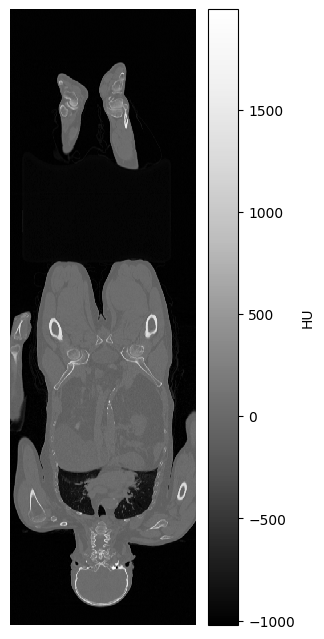

In [13]:
plt.figure(figsize=(3,8))
plt.pcolormesh(CT_coronal_slice.T, cmap='Greys_r')
plt.colorbar(label='HU')
plt.axis('off')
plt.show()

In [11]:
CT.shape

torch.Size([512, 512, 975])

In [14]:
channel_transform = EnsureChannelFirst()
CT = channel_transform(CT)
CT.shape

torch.Size([1, 512, 512, 975])

In [15]:
orientation_transform = Orientation(axcodes=('LPS'))
CT = orientation_transform(CT)

In [16]:
CT_coronal_slice = CT[0,:,256].cpu().numpy()

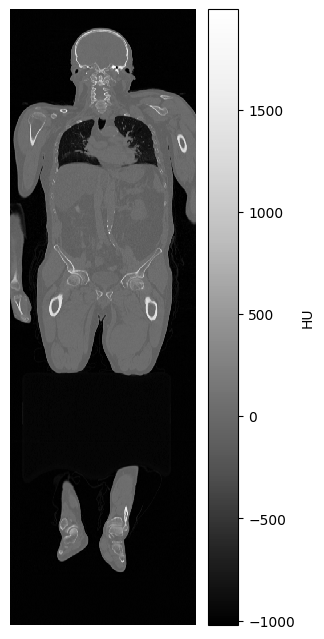

In [17]:
plt.figure(figsize=(3,8))
plt.pcolormesh(CT_coronal_slice.T, cmap='Greys_r')
plt.colorbar(label='HU')
plt.axis('off')
plt.show()

In [18]:
preprocessing_pipeline = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    Orientation(axcodes='LPS')
])

In [19]:
CT = preprocessing_pipeline(CT_folder)
CT_coronal_slice = CT[0,:,256].cpu().numpy()

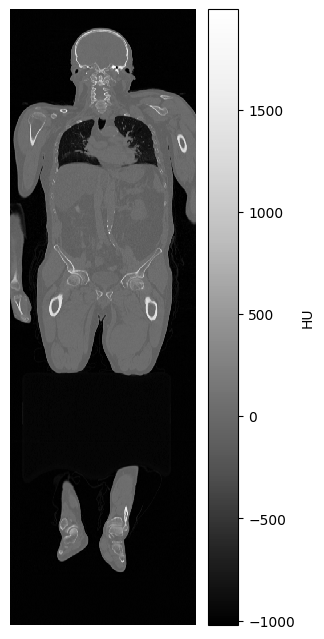

In [20]:
plt.figure(figsize=(3,8))
plt.pcolormesh(CT_coronal_slice.T, cmap='Greys_r')
plt.colorbar(label='HU')
plt.axis('off')
plt.show()

In [21]:
data = {'image': CT_folder, 'some_other_key': 42}

In [22]:
preprocessing_pipeline = Compose([
    LoadImaged(keys='image', image_only=True),
    EnsureChannelFirstd(keys='image'),
    Orientationd(keys='image',axcodes='LPS')
])

In [23]:
data = preprocessing_pipeline(data)

In [24]:
data

{'image': metatensor([[[[-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           ...,
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.]],
 
          [[-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           ...,
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.]],
 
          [[-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           

Segmentation Model

In [25]:
model_path = os.path.join(datadir, 'm_wb_ct_sgm', 'models', 'model_lowres.pt')
config_path = os.path.join(datadir, 'm_wb_ct_sgm', 'configs', 'inference.json')

In [26]:
config = ConfigParser()
config.read_config(config_path)

Preprocessing Pipeline

In [27]:
preprocessing = config.get_parsed_content("preprocessing")

In [ ]:
data = preprocessing({'image': CT_folder})

Model

In [1]:
model = config.get_parsed_content("network")

NameError: name 'config' is not defined

In [ ]:
model.load_state_dict(torch.load(model_path))
model.eval();

Inferer

In [ ]:
inferer = config.get_parsed_content("inferer")

Postprocessing

In [ ]:
postprocessing = config.get_parsed_content("postprocessing")

In [ ]:
data['image'].unsqueeze(0).shape

Prediction

In [ ]:
data = preprocessing({'image': CT_folder}) # returns a dictionary
# 2. Compute mask prediction, add it to dictionary
with torch.no_grad():
    # Have to add additional batch dimension to feed into model
    data['pred'] = inferer(data['image'].unsqueeze(0), network=model)
# Remove batch dimension in image and prediction
data['pred'] = data['pred'][0]
data['image'] = data['image'][0]
# Apply postprocessing to data
data = postprocessing(data)
segmentation = torch.flip(data['pred'][0], dims=[2])
segmentation = segmentation.cpu().numpy()

In [ ]:
slice_idx = 250
CT_coronal_slice = CT[0,:,slice_idx].cpu().numpy()
segmentation_coronal_slice = segmentation[:,slice_idx]

In [ ]:
plt.subplots(1,2,figsize=(6,8))
plt.subplot(121)
plt.pcolormesh(CT_coronal_slice.T, cmap='Greys_r')
plt.axis('off')
plt.subplot(122)
plt.pcolormesh(segmentation_coronal_slice.T, cmap='nipy_spectral')
plt.axis('off')
plt.show()

Computing bladder volume

In [ ]:
number_bladder_voxels = (segmentation==13).sum().item()
voxel_volume_cm3 = np.prod(CT.meta['spacing']/10)
bladder_volume = number_bladder_voxels * voxel_volume_cm3
print(f'Bladder Volume {bladder_volume:.1f}cm^3')